In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#From class we have
def cheb_mat_uniform(nx,order):
    x=np.linspace(-1.0,1.0,nx)
    mat=np.zeros([nx,order+1])
    #Recursion relation for Chebyshevs
    mat[:,0]=1.0
    if order>0:
        mat[:,1]=x
    if order>1:
        for i in range(1,order):
            mat[:,i+1]=2*x*mat[:,i]-mat[:,i-1]
    return mat,x


In [3]:
#Note, before fitting the Chebyshevs... 

#We need to figure out a way to map from whatever x domain we are interested in to
# x in -1, 1 (where Chebys are valid)

#Mapping...
def map_to_chevybounds(x):
    x_mapped = np.zeros(len(x))
    for i in range(len(x)):
        #Take each value, measure it's distance from min of orginal x and normalize to 2 so it fits in (-1,1).
        #Start at -1.0
        x_mapped[i] =  -1.0 + 2.0*(np.abs(x[i] - np.min(x))/(np.max(x) - np.min(x)))
    return x_mapped

Now, we should keep in mind $$\chi^2 = (d-Am)^T N^{-1}(d-Am)$$

and minimizing our chi-square gives us our best fit.

In the below cell, N is our noise matrix that we ignore (identity in this case since we want good values for log2!), $m$ is our best fit model parameters, $d$ in the equation is our data (y values for y = log2(x) in the cell below are our data). Thus, 

$$A^TAm = A^Ty$$

we solve for m and find,

$$m = (A^TA)^{-1}m = A^Ty$$

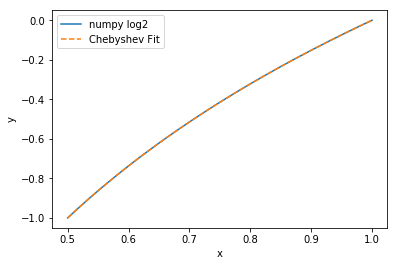

In [4]:
npoints=10000 #Number of points
order=150 #order of polynomial
ncoeff=8 #How many coefficients should we keep?

x = np.linspace(0.5, 1.0, npoints)

x_mapped = map_to_chevybounds(x) #Maps bounds to -1, 1

A, x_mapped = cheb_mat_uniform(npoints,order) #Gives us our chebyshev poly coefficients up to order

y = np.log2(x) #The actual data we want to fit, no noise

#Least-squares fit, mostly from class (see above mark down for explanation)
LHS=np.dot(A.transpose(),A) #Note, no noise
RHS=np.dot(A.transpose(),y) 
fit_parameters=np.dot(np.linalg.inv(LHS),RHS)


#A=A[:,1::2]

#print(fit_parameters)
#fit_parameters=fit_parameters[1::2]
#print(fit_parameters)

pred_cheb=np.dot(A[:,:ncoeff], fit_parameters[:ncoeff])

#print(fit_parameters[1::2])

#plt.title(r"log$_2$")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y, label='numpy log2')
plt.plot(x, pred_cheb, label='Chebyshev Fit', ls='--')
plt.legend()


('rms error for chebyshev is ', 1.9185635171270286e-07, ' with max error ', 3.196978251018834e-07)
('rms error for polyfit is ', 1.6726077605732667e-07, ' with max error ', 8.098967860803441e-07)


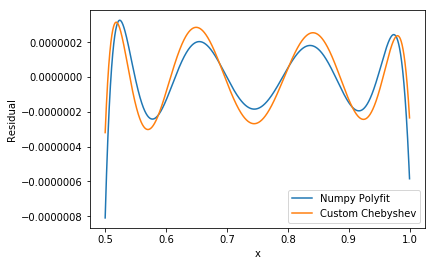

In [5]:
plt.xlabel("x")
plt.ylabel("Residual")

#plt.plot(x, y, label='numpy log2')
pred_poly = np.polyval(np.polyfit(x, y,ncoeff-1), x) #ncoeff-1 because we go to order+1 in chebyshev
plt.plot(x, y-pred_poly, label='Numpy Polyfit')
plt.plot(x, y-pred_cheb, label='Custom Chebyshev')
plt.legend()

print('rms error for chebyshev is ',np.sqrt(np.mean((pred_cheb-y)**2.0)),' with max error ',np.max(np.abs(pred_cheb-y)))
print('rms error for polyfit is ',np.sqrt(np.mean((pred_poly-y)**2.0)),' with max error ',np.max(np.abs(pred_poly-y)))


## 1a)
Our max errors are below $10^{-6}$, once we keep up to 8 terms in the Chebyshev fit. Although, our RMS is slightly larger than the polyfit to same order. 

We obtained the number of terms by trial and erorr, alternatively, we could examine the fit coefficients and then truncate right after the coefficient of the n-th order polynomial drops below our tolerance. 


## 1b)
The way we've coded this (with mapping of bounds to -1, 1 for chebyshev), we can already do the fit on any positive interval... But this give a bad fit. 

However, we can decompose the log2 to mantissa and exponent. By decomposing, our mantissa is always in the Cheby region (0, 1) comfortably, and mapping to -1, 1 doesn't do anything funny. Later, we fit the $\textit{mantissas}$ and add the exponent back at the end to exploit: 

$$ log_2 (m \times 2^{e}) =  log_2 (m) +e$$

Where m is the mantissa and e is the exponent.

This way, we get a good fit in a huge range!

An example outside the 0.5, 1.0 bounds is found below. In this case, Chebyshev does perform better than polyfit in both RMS and max error!

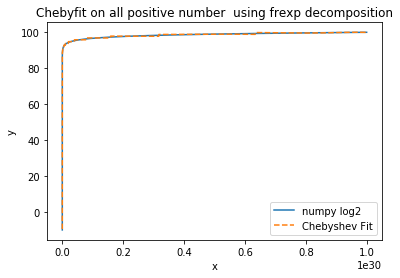

In [6]:
## Example outside of 0.5, 1 bounds... 


npoints=10000 #Number of points
order=150 #order of polynomial
ncoeff=8 #How many coefficients should we keep?

#log2(mantissa * 2^exp)
#log2(mantissa) + exp

x = np.linspace(1e-3,1e30,npoints)

mantissas, exponents = np.frexp(x)

#x_mant = np.linspace(np.min(mantissas), np.max(mantissas), npoints)

x_mapped = map_to_chevybounds(mantissas) #Maps bounds to -1, 1

A, x_mapped= cheb_mat_uniform(npoints,order) #Gives us our chebyshev poly coefficients up to order

#print(x_mapped)
y=np.log2(x) #The actual data, no noise

#Least-squares fit, mostly from class (see above mark down for explanation)
LHS=np.dot(A.transpose(),A) #Note, no noise
RHS=np.dot(A.transpose(),np.log2(mantissas)) #Remember, we are only fitting the mantissas now.
fit_parameters=np.dot(np.linalg.inv(LHS),RHS)


#A=A[:,1::2]

#print(fit_parameters)
#fit_parameters=fit_parameters[1::2]
#print(fit_parameters)

pred_cheb=np.dot(A[:,:ncoeff], fit_parameters[:ncoeff])+exponents #add back in the exponent.

#print(fit_parameters[1::2])

#print(exponents)

#plt.title(r"log$_2$")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y, label='numpy log2')
plt.plot(x, pred_cheb, label='Chebyshev Fit', ls='--')
plt.title('Chebyfit on all positive number  using frexp decomposition')
plt.legend()



('rms error for chebyshev is ', 0.24450733345112652, ' with max error ', 0.5535296175155935)
('rms error for polyfit is ', 1.0520493122101828, ' with max error ', 102.44189440712839)


/home/soud/.local/lib/python2.7/site-packages/numpy/lib/polynomial.py:578: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """


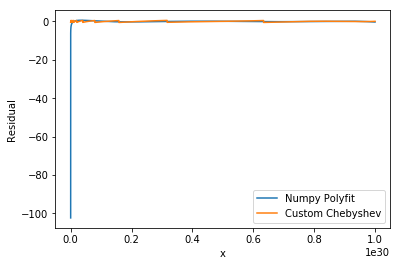

In [7]:
plt.xlabel("x")
plt.ylabel("Residual")

#plt.plot(x, y, label='numpy log2')
pred_poly = np.polyval(np.polyfit(x, y,ncoeff-1), x)
plt.plot(x, y-pred_poly, label='Numpy Polyfit')
plt.plot(x, y-pred_cheb, label='Custom Chebyshev')
plt.legend()

print('rms error for chebyshev is ',np.sqrt(np.mean((pred_cheb-y)**2.0)),' with max error ',np.max(np.abs(pred_cheb-y)))
print('rms error for polyfit is ',np.sqrt(np.mean((pred_poly-y)**2.0)),' with max error ',np.max(np.abs(pred_poly-y)))
